In [1]:
import numpy as np
import matplotlib.pylab as plt
from copy import copy as cp
import matplotlib.patches as patches

In [2]:
%matplotlib widget

In [3]:
# Simulation space dimensions, etc. edited by Clarke 02.21.2022
nx = 251 #orig 161
ny = 255
xmax,ymax = 1000.0, 1000.0 #micrometers

x = np.linspace(0,xmax,nx); dx = x[1]-x[0]; print('dx', dx)
y = np.linspace(0,ymax,ny); dy = y[1]-y[0]; print('dy',dy)
nxmid = int(nx/2); print('nxmid =', nxmid); print('x(nxmid) =',x[nxmid])
nymid = int(ny/2)
x = x-x[nxmid]
y = y-y[nymid]

# Define the box inside
Ldesiredx = 25. # Doesn't always work out to this because the grid is discretized
boxradx = int(Ldesiredx/dx)
Lx = boxradx*dx; print('Lx =', Lx)

Ldesiredy = 50.
boxrady = int(Ldesiredy/dy)
Ly = boxrady*dy; print('Ly =', Ly)

ixbox = [ix for ix in range(nxmid-boxradx,nxmid+boxradx)]; #print ixbox
iybox = [iy for iy in range(nymid-boxrady,nymid+boxrady)]; #print iybox
ixbot = min(ixbox); #print ixbot
iybot = min(iybox) #print ixbot
ixtop = max(ixbox); #print ixtop
iytop = max(iybox)
iylft = min(iybox); #print iylft
iyrgt = max(iybox); #rint iyrgt

dx 4.0
dy 3.937007874015748
nxmid = 125
x(nxmid) = 500.0
Lx = 24.0
Ly = 47.24409448818898


In [4]:
# Compute diffusion coefficient at this temperature
D_SI_300 = 24.0e-6 # m^2/s
D_300 = D_SI_300 * 1e6  # um^2/us
Temp = 260.0
Pressure = .2
acoef = 2.072
D = D_300*(Temp/300)**acoef/(Pressure/1.0); print(D_300, D)

# Here's the part that involved some guesswork ... getting the Neumann coefficient
gneumann_nu_kin = D/(nx-1); print('gneumann_kin', gneumann_nu_kin)
nu_kin_ml = 0.1633333333
kfactor = gneumann_nu_kin/nu_kin_ml; print('kfactor', kfactor)
alphasigma = .36; print('alpha*sigma', alphasigma)
gneumann = kfactor * nu_kin_ml; print('gneumann', gneumann)

# This is the far-field boundary
udirichlet = alphasigma

24.0 89.20943386022752
gneumann_kin 0.3568377354409101
kfactor 2.184720829675923
alpha*sigma 0.36
gneumann 0.3568377354409101


In [5]:
# Aesthetics ... fills in the box with an arbitrary constant value
def fillin(un,ixbox,iybox):
    border = cp(un[ixbox[0]-1,iybox[0]]); print('border=',border)
    for ix in ixbox:        
        for iy in iybox:
            un[ix,iy] = border
    return un

# Initialize u0 and un as ones/zeros matrices 
u0 = np.ones([nx, ny])*udirichlet # old u values
u0 = fillin(u0,ixbox, iybox)
u1 = cp(u0)

border= 0.36


In [6]:
# Physical parameters translated into values for computation
dx2 = dx**2
dy2 = dy**2
dt = (dx2+dy2)/D/10; print(dt)
Dxeff = D*dt/dx2
Dyeff = D*dt/dy2
gneumanneffx = gneumann*dt/dx**2; print('gneumann effective, x', gneumanneffx)
gneumanneffy = gneumann*dt/dy**2; print('gneumann effective, y', gneumanneffy)

# The differential equation solver
def propagate(u0_orig):
    
    # Diffusion
    u0 = cp(u0_orig)
    un = np.zeros(np.shape(u0))
    un[1:-1, 1:-1] = u0[1:-1, 1:-1] + ( \
    (u0[2:, 1:-1] - 2*u0[1:-1, 1:-1] + u0[:-2, 1:-1])*Dxeff + \
    (u0[1:-1, 2:] - 2*u0[1:-1, 1:-1] + u0[1:-1, :-2])*Dyeff )

    # Dirichlet outer boundary
    un[[0,-1],:]=udirichlet
    un[:,[0,-1]]=udirichlet
    
    # Neumann inner boundary
    un[ixbot-1,iybox] = u0[ixbot-1,iybox] +(u0[ixbot-2,iybox] - u0[ixbot-1,iybox])*Dxeff -gneumanneffx
    un[ixtop+1,iybox] = u0[ixtop+1,iybox] +(u0[ixtop+2,iybox] - u0[ixtop+1,iybox])*Dxeff -gneumanneffx
    un[ixbox,iylft-1] = u0[ixbox,iylft-1] +(u0[ixbox,iylft-2] - u0[ixbox,iylft-1])*Dyeff -gneumanneffy
    un[ixbox,iyrgt+1] = u0[ixbox,iyrgt+1] +(u0[ixbox,iyrgt+2] - u0[ixbox,iyrgt+1])*Dyeff -gneumanneffy
    
    # Also zero-out inside the box (this is just aesthetic)
    un = fillin(un,ixbox, iybox)
    
    return un


0.035310201664787995
gneumann effective, x 0.00078750077500155
gneumann effective, y 0.0008129023999999999


In [7]:
# Propagate forward a bunch of times
ntimes = 5000
un = propagate(u0)
for i in range(ntimes):
    un = propagate(un)

border= 0.3592124992249984
border= 0.3585800378176539
border= 0.35804156896687356
border= 0.3575722955058751
border= 0.3571534761140771
border= 0.3567743180394537
border= 0.3564267196094212
border= 0.35610512589760973
border= 0.35580523543276815
border= 0.3555238089346611
border= 0.3552582601100136
border= 0.3550065327442251
border= 0.3547669415957857
border= 0.35453809983833384
border= 0.354318845982977
border= 0.354108201027302
border= 0.3539053303126936
border= 0.35370951757814195
border= 0.35352014309238466
border= 0.35333666742815345
border= 0.35315861804190035
border= 0.352985578787095
border= 0.3528171812537053
border= 0.35265309777824544
border= 0.3524930356356774
border= 0.3523367322486927
border= 0.3521839511713086
border= 0.3520344787232437
border= 0.3518881211412594
border= 0.3517447021624176
border= 0.35160406095964924
border= 0.35146605037238043
border= 0.3513305353821293
border= 0.3511973917944831
border= 0.3510665050946423
border= 0.35093776945023697
border= 0.350811086

border= 0.3344246891711474
border= 0.33438703168562106
border= 0.3343494487093156
border= 0.33431193990448094
border= 0.3342745049359313
border= 0.33423714347101685
border= 0.33419985517959566
border= 0.33416263973400606
border= 0.33412549680903936
border= 0.3340884260819131
border= 0.33405142723224457
border= 0.33401449994202487
border= 0.333977643895593
border= 0.33394085877961066
border= 0.3339041442830375
border= 0.33386750009710614
border= 0.3338309259152982
border= 0.3337944214333204
border= 0.3337579863490807
border= 0.33372162036266556
border= 0.3336853231763166
border= 0.3336490944944082
border= 0.33361293402342523
border= 0.33357684147194094
border= 0.33354081655059564
border= 0.33350485897207494
border= 0.33346896845108887
border= 0.3334331447043512
border= 0.3333973874505588
border= 0.3333616964103714
border= 0.3333260713063918
border= 0.33329051186314607
border= 0.3332550178070642
border= 0.3332195888664609
border= 0.3331842247715169
border= 0.33314892525425993
border= 0.3

border= 0.3254375478750374
border= 0.32541350633284183
border= 0.32538949246684046
border= 0.3253655062085104
border= 0.32534154748959476
border= 0.3253176162421013
border= 0.325293712398301
border= 0.3252698358907266
border= 0.3252459866521712
border= 0.325222164615687
border= 0.3251983697145838
border= 0.3251746018824278
border= 0.3251508610530399
border= 0.3251271471604948
border= 0.3251034601391193
border= 0.3250797999234912
border= 0.3250561664484378
border= 0.3250325596490348
border= 0.32500897946060486
border= 0.3249854258187162
border= 0.32496189865918157
border= 0.3249383979180568
border= 0.3249149235316396
border= 0.32489147543646824
border= 0.3248680535693204
border= 0.3248446578672119
border= 0.32482128826739526
border= 0.3247979447073589
border= 0.32477462712482547
border= 0.3247513354577509
border= 0.32472806964432327
border= 0.32470482962296127
border= 0.3246816153323134
border= 0.32465842671125655
border= 0.324635263698895
border= 0.32461212623455904
border= 0.324589014

border= 0.3191206474560582
border= 0.3191027744145187
border= 0.3190849160835799
border= 0.3190670724376652
border= 0.31904924345126656
border= 0.31903142909894483
border= 0.31901362935532923
border= 0.31899584419511706
border= 0.3189780735930736
border= 0.3189603175240318
border= 0.31894257596289205
border= 0.3189248488846219
border= 0.3189071362642558
border= 0.3188894380768949
border= 0.3188717542977068
border= 0.31885408490192535
border= 0.3188364298648502
border= 0.3188187891618469
border= 0.3188011627683464
border= 0.31878355065984487
border= 0.31876595281190356
border= 0.3187483692001484
border= 0.31873079980026986
border= 0.31871324458802286
border= 0.3186957035392262
border= 0.31867817662976267
border= 0.31866066383557856
border= 0.31864316513268365
border= 0.3186256804971508
border= 0.3186082099051158
border= 0.31859075333277714
border= 0.31857331075639583
border= 0.3185558821522951
border= 0.31853846749686016
border= 0.31852106676653813
border= 0.3185036799378377
border= 0.3

border= 0.31403775484522156
border= 0.31402357271283043
border= 0.3140093996262318
border= 0.31399523557335873
border= 0.3139810805421689
border= 0.31396693452064484
border= 0.31395279749679367
border= 0.31393866945864707
border= 0.3139245503942612
border= 0.31391044029171666
border= 0.3138963391391184
border= 0.3138822469245957
border= 0.3138681636363021
border= 0.31385408926241515
border= 0.31384002379113657
border= 0.31382596721069217
border= 0.3138119195093317
border= 0.31379788067532866
border= 0.31378385069698056
border= 0.31376982956260857
border= 0.3137558172605576
border= 0.3137418137791962
border= 0.3137278191069164
border= 0.31371383323213375
border= 0.3136998561432873
border= 0.3136858878288395
border= 0.31367192827727597
border= 0.31365797747710567
border= 0.3136440354168607
border= 0.31363010208509634
border= 0.31361617747039083
border= 0.31360226156134546
border= 0.3135883543465844
border= 0.31357445581475474
border= 0.31356056595452636
border= 0.31354668475459185
border

border= 0.31003506292651817
border= 0.3100232011808655
border= 0.3100113456667669
border= 0.30999949637741464
border= 0.3099876533060124
border= 0.30997581644577527
border= 0.3099639857899297
border= 0.3099521613317134
border= 0.3099403430643754
border= 0.309928530981176
border= 0.30991672507538676
border= 0.30990492534029046
border= 0.30989313176918104
border= 0.30988134435536363
border= 0.3098695630921545
border= 0.30985778797288105
border= 0.3098460189908817
border= 0.30983425613950605
border= 0.30982249941211465
border= 0.30981074880207915
border= 0.30979900430278207
border= 0.309787265907617
border= 0.3097755336099885
border= 0.3097638074033119
border= 0.30975208728101356
border= 0.3097403732365307
border= 0.30972866526331133
border= 0.3097169633548143
border= 0.3097052675045093
border= 0.30969357770587663
border= 0.3096818939524076
border= 0.30967021623760405
border= 0.3096585445549786
border= 0.30964687889805453
border= 0.30963521926036575
border= 0.3096235656354568
border= 0.30

border= 0.3066369002787965
border= 0.3066266874424217
border= 0.3066164791733501
border= 0.3066062754673507
border= 0.3065960763201986
border= 0.30658588172767487
border= 0.3065756916855666
border= 0.30656550618966677
border= 0.3065553252357743
border= 0.306545148819694
border= 0.3065349769372368
border= 0.3065248095842193
border= 0.30651464675646417
border= 0.3065044884497999
border= 0.3064943346600608
border= 0.3064841853830872
border= 0.3064740406147251
border= 0.30646390035082655
border= 0.30645376458724927
border= 0.3064436333198569
border= 0.3064335065445188
border= 0.3064233842571102
border= 0.3064132664535121
border= 0.3064031531296112
border= 0.30639304428130015
border= 0.30638293990447724
border= 0.30637283999504644
border= 0.3063627445489176
border= 0.30635265356200614
border= 0.3063425670302334
border= 0.3063324849495262
border= 0.30632240731581717
border= 0.3063123341250446
border= 0.30630226537315247
border= 0.3062922010560904
border= 0.3062821411698136
border= 0.30627208

border= 0.30360814887980986
border= 0.3035991993688096
border= 0.30359025333339434
border= 0.3035813107707767
border= 0.30357237167817275
border= 0.3035634360528018
border= 0.30355450389188665
border= 0.30354557519265357
border= 0.3035366499523321
border= 0.3035277281681552
border= 0.3035188098373593
border= 0.3035098949571841
border= 0.3035009835248727
border= 0.3034920755376715
border= 0.30348317099283034
border= 0.3034742698876024
border= 0.30346537221924413
border= 0.30345647798501546
border= 0.3034475871821795
border= 0.3034386998080028
border= 0.30342981585975515
border= 0.3034209353347097
border= 0.30341205823014294
border= 0.30340318454333465
border= 0.3033943142715679
border= 0.303385447412129
border= 0.3033765839623076
border= 0.3033677239193967
border= 0.30335886728069256
border= 0.3033500140434946
border= 0.30334116420510554
border= 0.3033323177628315
border= 0.3033234747139817
border= 0.3033146350558687
border= 0.3033057987858083
border= 0.30329696590111954
border= 0.30328

border= 0.30091590989756656
border= 0.30090794389555214
border= 0.30089998062709056
border= 0.30089202009024946
border= 0.30088406228309855
border= 0.3008761072037096
border= 0.3008681548501566
border= 0.3008602052205155
border= 0.3008522583128642
border= 0.30084431412528295
border= 0.30083637265585383
border= 0.3008284339026611
border= 0.30082049786379106
border= 0.300812564537332
border= 0.30080463392137435
border= 0.3007967060140105
border= 0.300788780813335
border= 0.30078085831744433
border= 0.30077293852443704
border= 0.3007650214324138
border= 0.3007571070394772
border= 0.300749195343732
border= 0.3007412863432848
border= 0.3007333800362444
border= 0.30072547642072145
border= 0.30071757549482886
border= 0.3007096772566813
border= 0.30070178170439565
border= 0.30069388883609066
border= 0.3006859986498872
border= 0.3006781111439081
border= 0.30067022631627816
border= 0.3006623441651242
border= 0.3006544646885751
border= 0.3006465878847616
border= 0.3006387137518166
border= 0.30063

border= 0.29851822599719013
border= 0.298511039578967
border= 0.2985038553721444
border= 0.29849667337532343
border= 0.29848949358710647
border= 0.2984823160060973
border= 0.29847514063090114
border= 0.2984679674601244
border= 0.29846079649237484
border= 0.29845362772626166
border= 0.29844646116039536
border= 0.29843929679338776
border= 0.29843213462385204
border= 0.29842497465040263
border= 0.29841781687165536
border= 0.2984106612862274
border= 0.29840350789273723
border= 0.29839635668980463
border= 0.29838920767605076
border= 0.298382060850098
border= 0.29837491621057016
border= 0.2983677737560923
border= 0.29836063348529085
border= 0.29835349539679357
border= 0.2983463594892294
border= 0.2983392257612287
border= 0.29833209421142315
border= 0.29832496483844567
border= 0.29831783764093056
border= 0.2983107126175134
border= 0.298303589766831
border= 0.29829646908752167
border= 0.29828935057822475
border= 0.29828223423758105
border= 0.2982751200642327
border= 0.29826800805682296
border=

border= 0.2963965076787647
border= 0.29638994398572455
border= 0.2963833821283937
border= 0.29637682210571864
border= 0.29637026391664667
border= 0.29636370756012603
border= 0.29635715303510596
border= 0.2963506003405366
border= 0.29634404947536896
border= 0.29633750043855495
border= 0.2963309532290474
border= 0.29632440784580016
border= 0.29631786428776785
border= 0.2963113225539061
border= 0.29630478264317134
border= 0.29629824455452103
border= 0.2962917082869135
border= 0.2962851738393079
border= 0.2962786412106645
border= 0.29627211039994417
border= 0.2962655814061089
border= 0.2962590542281216
border= 0.2962525288649459
border= 0.2962460053155465
border= 0.29623948357888896
border= 0.29623296365393964
border= 0.29622644553966593
border= 0.29621992923503604
border= 0.296213414739019
border= 0.296206902050585
border= 0.2962003911687048
border= 0.29619388209235026
border= 0.29618737482049406
border= 0.2961808693521098
border= 0.2961743656861719
border= 0.2961678638216558
border= 0.29

border= 0.29445087006638937
border= 0.294444827584268
border= 0.2944387866513655
border= 0.2944327472668681
border= 0.2944267094299625
border= 0.2944206731398363
border= 0.2944146383956775
border= 0.29440860519667494
border= 0.29440257354201804
border= 0.29439654343089683
border= 0.294390514862502
border= 0.29438448783602494
border= 0.2943784623506576
border= 0.29437243840559274
border= 0.2943664160000235
border= 0.2943603951331439
border= 0.2943543758041484
border= 0.2943483580122323
border= 0.29434234175659146
border= 0.2943363270364223
border= 0.294330313850922
border= 0.2943243021992883
border= 0.2943182920807196
border= 0.29431228349441496
border= 0.2943062764395741
border= 0.29430027091539723
border= 0.2942942669210854
border= 0.2942882644558401
border= 0.29428226351886366
border= 0.2942762641093588
border= 0.29427026622652913
border= 0.29426426986957865
border= 0.2942582750377122
border= 0.29425228173013507
border= 0.29424628994605334
border= 0.2942402996846736
border= 0.2942343

border= 0.292648128942805
border= 0.29264253069373647
border= 0.29263693376962885
border= 0.29263133816984055
border= 0.2926257438937304
border= 0.29262015094065785
border= 0.2926145593099826
border= 0.2926089690010649
border= 0.29260338001326563
border= 0.2925977923459459
border= 0.29259220599846747
border= 0.2925866209701924
border= 0.2925810372604834
border= 0.2925754548687035
border= 0.29256987379421634
border= 0.29256429403638584
border= 0.2925587155945766
border= 0.29255313846815345
border= 0.2925475626564819
border= 0.2925419881589279
border= 0.2925364149748577
border= 0.2925308431036382
border= 0.2925252725446366
border= 0.2925197032972207
border= 0.2925141353607587
border= 0.2925085687346193
border= 0.29250300341817154
border= 0.29249743941078515
border= 0.29249187671183013
border= 0.292486315320677
border= 0.2924807552366967
border= 0.2924751964592607
border= 0.29246963898774087
border= 0.2924640828215096
border= 0.2924585279599397
border= 0.2924529744024045
border= 0.2924474

border= 0.29097836110133296
border= 0.29097314387141265
border= 0.29096792778859093
border= 0.2909627128523524
border= 0.29095749906218205
border= 0.29095228641756515
border= 0.2909470749179874
border= 0.2909418645629348
border= 0.2909366553518938
border= 0.290931447284351
border= 0.29092624035979353
border= 0.29092103457770885
border= 0.29091582993758464
border= 0.2909106264389091
border= 0.29090542408117065
border= 0.29090022286385814
border= 0.2908950227864607
border= 0.29088982384846784
border= 0.29088462604936943
border= 0.2908794293886557
border= 0.2908742338658171
border= 0.29086903948034465
border= 0.29086384623172956
border= 0.2908586541194634
border= 0.29085346314303806
border= 0.2908482733019459
border= 0.29084308459567954
border= 0.2908378970237319
border= 0.29083271058559634
border= 0.2908275252807665
border= 0.29082234110873634
border= 0.29081715806900027
border= 0.2908119761610529
border= 0.29080679538438936
border= 0.29080161573850494
border= 0.2907964372228954
border= 

border= 0.2893793797273837
border= 0.2893745020398976
border= 0.28936962535219657
border= 0.2893647496638623
border= 0.2893598749744767
border= 0.28935500128362207
border= 0.289350128590881
border= 0.28934525689583623
border= 0.28934038619807084
border= 0.28933551649716815
border= 0.2893306477927117
border= 0.28932578008428544
border= 0.2893209133714734
border= 0.28931604765386
border= 0.2893111829310298
border= 0.28930631920256783
border= 0.28930145646805916
border= 0.28929659472708924
border= 0.2892917339792438
border= 0.28928687422410876
border= 0.28928201546127036
border= 0.2892771576903151
border= 0.28927230091082967
border= 0.2892674451224011
border= 0.28926259032461665
border= 0.2892577365170639
border= 0.2892528836993305
border= 0.2892480318710046
border= 0.2892431810316745
border= 0.28923833118092873
border= 0.28923348231835616
border= 0.28922863444354585
border= 0.2892237875560872
border= 0.2892189416555697
border= 0.2892140967415833
border= 0.2892092528137181
border= 0.28920

border= 0.2878628161816028
border= 0.28785823930185167
border= 0.28785366330012835
border= 0.2878490881760895
border= 0.28784451392939187
border= 0.2878399405596925
border= 0.2878353680666485
border= 0.2878307964499174
border= 0.2878262257091567
border= 0.2878216558440243
border= 0.2878170868541782
border= 0.28781251873927655
border= 0.2878079514989778
border= 0.2878033851329406
border= 0.28779881964082377
border= 0.2877942550222863
border= 0.2877896912769874
border= 0.28778512840458653
border= 0.28778056640474337
border= 0.2877760052771177
border= 0.2877714450213696
border= 0.28776688563715924
border= 0.28776232712414707
border= 0.2877577694819938
border= 0.28775321271036014
border= 0.28774865680890727
border= 0.2877441017772963
border= 0.2877395476151888
border= 0.28773499432224625
border= 0.28773044189813063
border= 0.28772589034250395
border= 0.2877213396550284
border= 0.2877167898353664
border= 0.2877122408831807
border= 0.2877076927981341
border= 0.2877031455798895
border= 0.2876

border= 0.2864585119069042


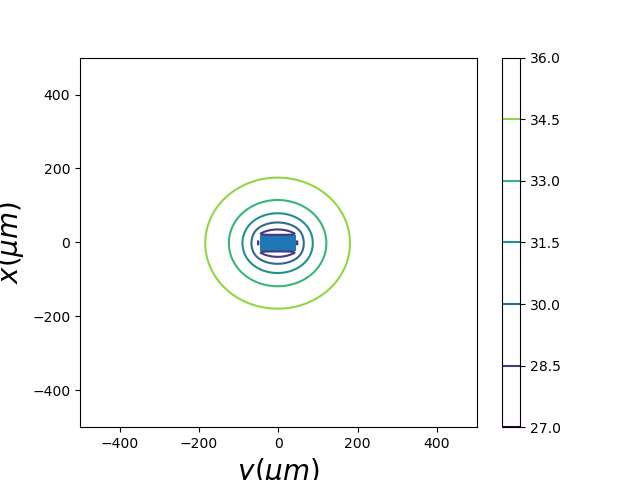

In [8]:
# Graph as contour plot
fig,ax = plt.subplots()
CS = ax.contour(y,x,un*100)
ax.set_xlabel(r'$y (\mu m)$', fontsize=20)
ax.set_ylabel(r'$x (\mu m)$', fontsize=20)
#plt.xlim([25, 50])

fig.colorbar(CS)
ax.add_patch(patches.Rectangle((y[iybox[0]],x[ixbox[0]]), Ly*2-dy, Lx*2-dx))

c_r = 0.3784974465995239
[ 7.86295776e-06 -3.21252526e-12  2.84734137e-01]
c_r = 1.1968417173509105
[ 5.72567273e-06 -4.62877762e-12  2.74263449e-01]


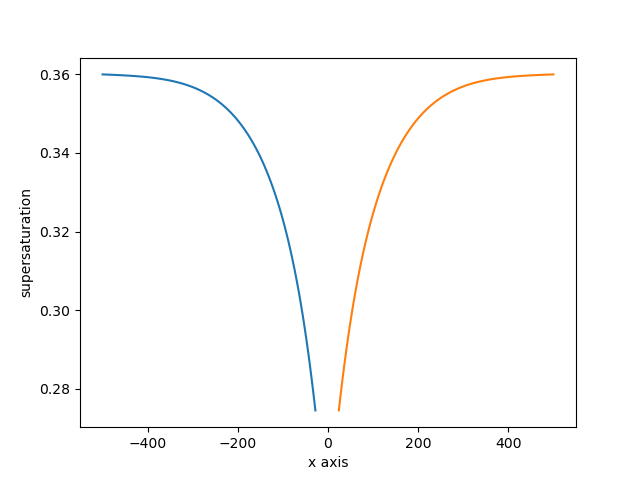

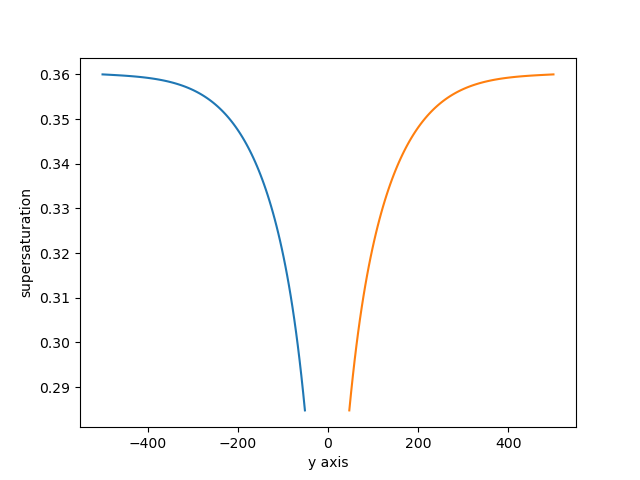

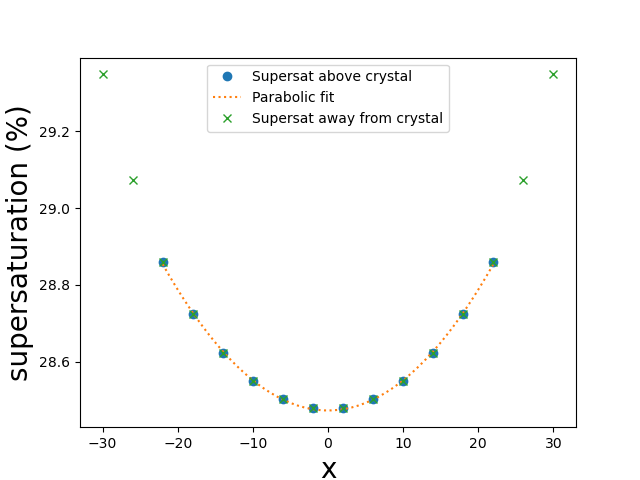

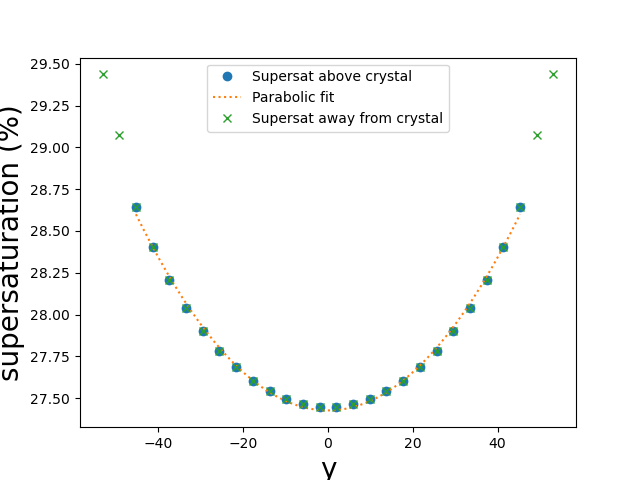

In [9]:
# Show slices through the result

#First, we look in the x direction at a fixed y value
# Just a slice down the middle 
plt.figure()
plt.plot(x[:ixbot],un[:ixbot,nymid])
plt.plot(x[ixtop+1:],un[ixtop+1:,nymid])
plt.xlabel("x axis")
plt.ylabel("supersaturation")

#Now we look at the y direction, fixed x value
plt.figure()
plt.plot(y[:iybot],un[nxmid, :iybot])
plt.plot(y[iytop+1:],un[nxmid, iytop+1:])
plt.xlabel("y axis")
plt.ylabel("supersaturation")

# Now a slice just across one of the box surfaces ( in the x dimension)
plt.figure()
#uscaled = un[ixbox,nymid+boxrad]/max(un[ixbox,nymid+boxrad])
uscaled = un[ixbox,nymid+boxrady]
print('c_r =', (max(uscaled)-min(uscaled))*100)
xshifted = x[ixbox]-x[nxmid]+dx/2
plt.plot(xshifted,uscaled*100,'o')
p = np.polyfit(xshifted,uscaled,2); print(p)
xshifted_theory = np.linspace(min(xshifted),max(xshifted))
plt.plot(xshifted_theory,np.polyval(p,xshifted_theory)*100,':')

iextend = 2
bigixbox = [ix for ix in range(nxmid-boxradx-iextend,nxmid+boxradx+iextend)]
biguscaled = un[bigixbox,nymid+boxrady]
bigxshifted = x[bigixbox]-x[nxmid]+dx/2
plt.plot(bigxshifted,biguscaled*100,'x',lw=2)
plt.xlabel('x',fontsize=20)
plt.ylabel('supersaturation (%)',fontsize=20)
# plt.xlim([-L*1.,L*1.1])

plt.legend(['Supersat above crystal','Parabolic fit','Supersat away from crystal'],loc='upper center')


# Now a slice just across one of the box surfaces ( in the Y dimension)
plt.figure()
#uscaled = un[ixbox,nymid+boxrad]/max(un[ixbox,nymid+boxrad])
uscaled = un[nxmid+boxradx, iybox]
print('c_r =', (max(uscaled)-min(uscaled))*100)
yshifted = y[iybox]-y[nymid]+dy/2
plt.plot(yshifted,uscaled*100,'o')
#fitted line
p = np.polyfit(yshifted,uscaled,2); print(p)
yshifted_theory = np.linspace(min(yshifted),max(yshifted))
plt.plot(yshifted_theory,np.polyval(p,yshifted_theory)*100,':')

iextend = 2
bigiybox = [iy for iy in range(nymid-boxrady-iextend,nymid+boxrady+iextend)]
biguscaled = un[nxmid+boxradx,bigiybox]
bigyshifted = y[bigiybox]-y[nymid]+dy/2
plt.plot(bigyshifted,biguscaled*100,'x',lw=2)
plt.xlabel('y',fontsize=20)
plt.ylabel('supersaturation (%)',fontsize=20)
# plt.xlim([-L*1.,L*1.1])

plt.legend(['Supersat above crystal','Parabolic fit','Supersat away from crystal'],loc='upper center')